<h1><center>Obliczenia ewolucyjne</center></h1>
<h3><center><ul style="list-style: none;">
    <li>Jakub Kurek 234078</li>
    <li>Mateusz Gałasiński 234054</li>
    </ul></center></h3> 
<h2><center>Zadanie 3 - Optymalizacja z wykorzystaniem wzorca</center></h2>

## Instalacja zależności

In [1]:
!pip install deap > /dev/null
!pip install matplotlib > /dev/null
!pip install tabulate > /dev/null
%matplotlib notebook

## Obsługa konfiguracji oraz import bibliotek

### Imports

In [2]:
from tabulate import tabulate
from IPython.display import display, HTML
import itertools
import math
import operator
import random
from statistics import mean
import time

import numpy
np = numpy
from deap import base
from deap import benchmarks #import rosenbrock, griewank, ackley, schwefel, schaffer
from deap import creator
from deap import tools

#plots
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from functools import reduce
#random
from numpy import random as nrand
nrand.seed(0)
from random import seed
seed(0)
#constants
COLUMN_HIGHLIGHT='#9AD10F'

<div>Setting styles</div>
<style>
div.ui-dialog-titlebar.ui-widget-header {display: none;}
</style>
<style>
div.ui-dialog-titlebar {display: none;}
</style>

In [3]:
HTML("<style>div.inline {display: inline-block; padding: 0;}</style>")

In [4]:
from pathlib import Path
import json
class Config(object): 
    def __init__(self, TYPE, MIN_COORD, MAX_COORD, FUNCTION, CHI, C, P, BOA_C, BOA_A, DIMS, NPARTICLES, NEXCESS, RCLOUD, EVALS):
        self.CHI = CHI        
        self.TYPE = TYPE
        self.MIN_COORD = MIN_COORD
        self.MAX_COORD = MAX_COORD
        self.FUNCTION = FUNCTION
        self.C = C
        self.P = P
        self.BOA_C = BOA_C
        self.BOA_A = BOA_A
        self.DIMS = DIMS
        self.NPARTICLES = NPARTICLES
        self.NEXCESS = NEXCESS
        self.RCLOUD = RCLOUD
        self.EVALS = EVALS

def as_config(dct):
    return Config(
        dct['TYPE'],
        dct['MIN_COORD'], 
        dct['MAX_COORD'], 
        dct['FUNCTION'], 
        dct['CHI'],
        dct['C'],
        dct['P'],
        dct['BOA_C'],
        dct['BOA_A'],
        dct['DIMS'],
        dct['NPARTICLES'], 
        dct['NEXCESS'], 
        dct['RCLOUD'],
        dct['EVALS'],
        )

load_config = lambda : json.loads(json_config, object_hook = as_config)

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

colorize = lambda text, patterns: reduce(lambda a,b: a.replace(b, cstr(b, color=COLUMN_HIGHLIGHT)) , patterns, text)
colorize_column = lambda table, col_name: colorize(table, [col_name])
def tabulate_config(col_name=None):
    table = tabulate([[cfg.TYPE, cfg.MIN_COORD, cfg.MAX_COORD, cfg.FUNCTION, cfg.CHI, cfg.TYPE, cfg.C, cfg.P, cfg.DIMS, cfg.NPARTICLES, cfg.NEXCESS, cfg.RCLOUD, cfg.BOA_C, cfg.BOA_A]],
                     headers=["TYPE", "MIN_COORD", "MAX_COORD", "FUNCTION", "CHI", "TYPE", "C", "P", "DIMS", "NPARTICLES", "NEXCESS", "RCLOUD", "BOA_C", "BOA_A"],
                     tablefmt="html")
    if col_name:
        display(HTML(colorize_column(table, col_name)))
    else:
        display(HTML(table))

# Algorytmy PSO oraz BOA

<div style="text-align: justify">
Implementacja algorytmów odbyła się z wykorzstaniem biblioteki DEAP dla języka Python
<h4>MPSO</h4>
Zasotosowany algorytm PSO pozostał taki sam jak w zadaniu I oraz zadaniu II (w wariancie MPSO).
<h4>BOA</h4>
Pełny opis oryginalnego algorytmu BOA znajdue się w <a href="https://ftims.edu.p.lodz.pl/pluginfile.php/140849/mod_resource/content/1/BOA.pdf">"Butterfly optimization algorithm: a novel approach for global optimization"</a>. Od klasycznego PSO odróżnia się zastosowaniem operatora lokalnego przeszukiwania oraz innej formuły aktualizacji położenia cząstek, inspirowanej ruchami motyli. Opiera się ona o wykorzystanie informacji o "zapachu" (ang. <i>fragrance</i>) danego motyla, która wpływa na poruszanie się cząstki w taki sposób, aby cząstki, które znajdują się w rozwiązaniach o wyższej wartości funkcji przystosowania, miały większy wpływ na przeszukiwane obszary. Wysokość współczynnika zapachu zależy od stałego mnożnika, wartości funkcji przystosowania oraz wykładnika, który odzwierciedla wpływ ośrodka rozchodzenia się zapachu. Wykładnik ten zwiększany jest wraz z następującymi iteracjami, zgodnie z formułą z oryginalnego algorytmu, zapewniającą malejący wzrost.
</div>

## Metody oraz klasy definujące badane algorytmy

### Update particles

In [5]:
def updateParticleMPSO(part, best, chi, c):
    ce1 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce2 = (c * random.uniform(0, 1) for _ in range(len(part)))
    ce1_p = map(operator.mul, ce1, map(operator.sub, best, part))
    ce2_g = map(operator.mul, ce2, map(operator.sub, part.best, part))
    a = map(operator.sub,
                      map(operator.mul,
                                    itertools.repeat(chi),
                                    map(operator.add, ce1_p, ce2_g)),
                      map(operator.mul,
                                     itertools.repeat(1 - chi),
                                     part.speed))
    part.speed = list(map(operator.add, part.speed, a))
    part[:] = list(map(operator.add, part, part.speed))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]
    
def updateEliteParticles(population):
    for updateSwarm in population:
        lbest = [swarm[0] for swarm in population if swarm != updateSwarm]
        mean = np.mean(lbest, axis=0)
        N = nrand.uniform(1, 2, len(updateSwarm.best))
        updateSwarm[0][:] = list(map(operator.mul,
                           mean,
                           N))
from math import pow
def updateParticleBOA(rand_part_1, rand_part_2, part, best, c, a, p):
    r = random.uniform(0, 1)
    fragrance = c*(pow(part.fitness.values[0], a))
    r1 = (r**2 * rand_part_1[i] - rand_part_2[i] for i in range(len(part)))
    if r < p:
        move = map(operator.mul,
                   map(operator.sub,
                       map(operator.mul,
                           itertools.repeat(r**2),
                           best),
                       part),
                itertools.repeat(fragrance))
    else:
        move = map(operator.mul,
                   itertools.repeat(fragrance),
                   r1)
    part[:] = list(map(operator.add, part, move))
    part[:] = [BOUNDS[0] if v < BOUNDS[0] else BOUNDS[1] if v > BOUNDS[1] else v for v in part[:]]

### Toolbox for DEAP framework

In [6]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Particle", list, fitness=creator.FitnessMin, speed=list, 
    best=None, bestfit=creator.FitnessMin)
creator.create("Swarm", list, best=None, bestfit=creator.FitnessMin)

def generate(pclass, dim, pmin, pmax, smin, smax):
    part = pclass(random.uniform(pmin, pmax) for _ in range(dim)) 
    part.speed = [random.uniform(smin, smax) for _ in range(dim)]
    return part

def genetic_config(toolbox):
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=cfg.NPARTICLES//5)
    return toolbox

def setup_toolbox(BOUNDS, mpb):    
    toolbox = base.Toolbox()
    toolbox.register("particle", generate, creator.Particle, dim=cfg.DIMS,
        pmin=BOUNDS[0], pmax=BOUNDS[1], smin=-(BOUNDS[1] - BOUNDS[0])/2.0,
        smax=(BOUNDS[1] - BOUNDS[0])/2.0)
    toolbox.register("swarm", tools.initRepeat, creator.Swarm, toolbox.particle)
    if cfg.TYPE == "MPSO":
        toolbox.register("update", updateParticleMPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "MSPSO":
        toolbox.register("update", updateParticleMSPSO, chi=cfg.CHI, c=cfg.C)
    elif cfg.TYPE == "BOA":
        toolbox.register("update", updateParticleBOA, p=cfg.P)
    else:
        toolbox.register("update", updateParticleMPSO, chi=cfg.CHI, c=cfg.C)
    toolbox.register("evaluate", mpb)
    toolbox.register("eliteupdate", updateEliteParticles)
    return genetic_config(toolbox)

# Algorytm genetyczny
<br>
<div style="text-align: justify;">Algorytm genetyczny (ang. <i>genetic algorithm</i>) -
jest jedną z ewolucyjnych metod
optymalizacji. Zalicza się go do klasy
algorytmów heurystycznych.
Przeszukiwanie możliwych rozwiązań w
celu znalezienia rozwiązania najlepszego
lub potencjalnie najlepszego odbywa się za
pomocą mechanizmów ewolucji oraz
doboru naturalnego.
</div>
<div> Koncepcyjnie algorytm składa się z następujących kroków:
<ol>
    <li>Inicjujemy (najczęściej w sposób losowy) pewną
początkową populację osobników</li>
    <li>Poddajemy każdego z nich ocenie</li>
    <li>Z populacji wybieramy osobniki najlepiej
do tego przystosowane</li>
    <li>Za pomocą operacji genetycznych
(krzyżowanie oraz mutacja) tworzymy
nowe pokolenie</li>
    <li>Powrót do punktu 2</li>
</ol>
</div>
<div style="text-align: justify;"> Potencjalne rozwiązania traktowane są jako
osobniki populacji. Algorytm symuluje proces
naturalnej selekcji poprzez ocenę przystosowania
poszczególnych osobników, eliminację osobników
słabszych i krzyżowanie ze sobą osobników
najsilniejszych. Wynikiem działania algorytmu
genetycznego jest populacja najlepiej
przystosowanych osobników, wśród których
może znajdować się najlepsze rozwiązanie.
Jednocześnie najlepiej przystosowane osobniki nie
muszą leżeć blisko siebie w przestrzeni rozwiązań.
</div><p><br></p>
<div>
    Ustawiono następujące wartości parametrów konfiguracyjnych dla algorytmu genetycznego:
</div>
<ul>
    <li>Prawdopodobieństwo mutacji (<i>mutpb</i>) - 0.2</li>
    <li>Prawdopodobieństwo krzyżowania (<i>cxpb</i>, ang. crossover probability) - odstetek w jakim nowa populacja składa się z krzyżówek, a w jakim stopniu z niezmienionych osobników</li>
    <li>Metoda selekcji (<i>select</i>) - selekcja turniejowa, rozmiar turnieji (<i>tournsize</i>) wynosi 20% populacji</li>
    <li>Typ krzyżowania (<i>mate</i>) - "cxTwoPoint" oznacza krzyżowanie typu <i>two point crossover</i>, w którym losuje się dwa punkty dzielące chromosomy rodziców na trzy części. Dzieci powstają poprzez zamianę miejscami środkowego odcinka chromosomów rodziców.
</ul>

In [7]:
from deap import algorithms

def genetic(pop, toolbox, hof):
    return algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, halloffame=hof, verbose=False)[0]

### Klasa "pętli algorytmu"
Zastosowany algorytm opiera się na aktualizacji położenia cząstek zgodnie z wybranym algorytmem optymalizacji rojem cząstek - PSO lub BOA - zmodyfikowanym w taki sposób, że do nadawania kierunku przyspieszenia cząstek roju wykorzystywany jest wzorzec, będący najlepszym osobnikiem po ewolucji zgodnie z algorytmem genetycznym, który w każdej iteracji korzysta również z informacji zdobytej dzięki przeszukiwaniu algorytmem "roju".

In [8]:
class App():
    def register_stats(self):
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", numpy.mean)
        stats.register("std", numpy.std)
        stats.register("min", numpy.min)
        stats.register("max", numpy.max)        
        logbook = tools.Logbook()
        logbook.header = "evals", "error", "avg", "max"
        return stats, logbook

    def saveResults(self, logbook, swarm, nevals):
        logbook.record(evals=nevals, error=abs(swarm.bestfit.wvalues[0]), **stats.compile(swarm))

    ###############
    ##### Main #####
    ###############
    def process(self, should_plot):
        hof = tools.HallOfFame(1)
        nevals = 0
        swarm = toolbox.swarm(n=cfg.NPARTICLES)
        generation=0
        while nevals < cfg.EVALS:
            swarm = genetic(swarm, toolbox, hof)
            for part in swarm:
                part.fitness.values = toolbox.evaluate(part)
                nevals += 1
                if swarm.best and part.best: # if already calculated first iteration
                    if cfg.TYPE == "BOA":
                        toolbox.update(random.choice(swarm), random.choice(swarm), part, hof[0], cfg.BOA_C, cfg.BOA_A)
                    else:
                        toolbox.update(part, hof[0])
                # Update swarm's attractors personal best and global best
                if not part.best or part.fitness > part.bestfit:
                    part.best = toolbox.clone(part[:])
                    part.bestfit.values = part.fitness.values
                if not swarm.best or part.fitness > swarm.bestfit:
                    swarm.best = toolbox.clone(part[:])
                    swarm.bestfit.values = part.fitness.values
            self.saveResults(logbook, swarm, nevals)
            generation += 1
            if cfg.TYPE == "BOA":
                cfg.BOA_A=cfg.BOA_A+(0.025/(cfg.BOA_A*generation))
        return logbook

    def run(self, should_plot=True):
        global BOUNDS, toolbox, stats, logbook, mpb
        BOUNDS = [cfg.MIN_COORD, cfg.MAX_COORD]
        mpb = getattr(benchmarks, cfg.FUNCTION)
        toolbox = setup_toolbox(BOUNDS, mpb)
        stats, logbook = self.register_stats()
        start_time = time.time()
        result = self.process(should_plot)
        return result, (time.time() - start_time)

def plot_means_from_runs(runs, names):
    fig, axes = plt.subplots(len(names), 1, sharex=True, figsize=(10,8))
    for i, col_name in enumerate(names):
        min_len = np.min([len(run[0].select(col_name)) for run in runs])
        values = [x[0].select(col_name)[0:min_len] for x in runs]
        mean_values = np.mean(values, axis=0)
        plot_titled(mean_values, axes[i], f"Mean {col_name} across generations taken from {len(runs)} runs")

def run_n_times(n, col_name=None):
    tabulate_config(col_name)
    results = [App().run(should_plot=False) for _ in range(n)]
    print("--- Mean computation time %.4f seconds ---" % np.mean([x[1] for x in results]))
    print("--- Mean solution %.4f ---" % np.mean(flatten(x[0].select("error") for x in results)))
    print("--- Mean std %.4f ---" % np.mean(flatten(x[0].select("std") for x in results)))
    plot_means_from_runs(results, ["error", "std"])

# Badania

Konfiguracja wspólna dla wszystkich testów:
* n_runs - ilość uruchomień danego algorytmu w ramach jednego testu
* json_config - domyślne wartości parametrów algorytmów

In [9]:
n_runs = 30
json_config ="""
{
    "TYPE": "MPSO",
    "FUNCTION": "ackley",
    "MIN_COORD": -15,
    "MAX_COORD": 30,
    "CHI": 0.729843788,
    "C": 2.05,
    "BOA_C": 0.01,
    "BOA_A": 0.1,
    "DIMS": 3,
    "NPARTICLES": 20,
    "NEXCESS": 1,
    "RCLOUD": 0.5,
    "EVALS": 10000,
    "P": 0.8
}"""

### Plot functions

In [10]:
flatten = lambda l: [item for sublist in l for item in sublist]
figsize = (14, 8)
def annot_min(x,y, ax=None, x_pos_mod=1, y_pos_mod=-0.06):
    xmin = x[np.argmin(y)]
    ymin = y.min()
    text= "x={:.3f}, y={:.3f}".format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops,
              bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmin, ymin), xytext=(0.5,-0.02), **kw)

def plot_titled(y, ax, title):
    ax.set_title(title)
    ax.scatter(range(len(y)), y, c=y, cmap='coolwarm');
    annot_min(range(len(y)), y, ax=ax)
    plt.show()

def plot_error(result_book):
    error = result_book.select("error")
    error = np.array(error)
    fig = plt.figure(figsize=figsize, dpi=50)
    ax = plt.axes(title="Error across generations")
    # ax.scatter(range(len(error)), error, s=10, c=error, cmap='coolwarm')
    ax.plot(range(len(error)), error)
    annot_min(range(len(error)), error)
    plt.show()

### Testy
<style>div.inline { color: #9AD10F; display: inline-block; padding: 0;}</style>
<div style="text-align: justify">
Przeprowadzono szereg eksperymentalnych uruchomień dla każdego algorytmu. Pierwsze uruchomienie przeprowadzone jest dla wstępnie dobranych parametrów, następnie jedna z wartości konfiguracyjnych jest zmieniana względem pierwotnej konfiguracji (w wyświetlanej tabeli oznaczono ją dodatkowo kolorem <div class="inline" style=color:#9AD10F> zielonym </div>). 
</div>
<div style="text-align: justify">
Na początku testów dla danego algorytmu wczytywana jest na nowo domyślna konfiguracja, wywołaniem funkcji <i>load_config</i>, podlegająca dalej odpowiednim zmianom.
</div>
<div style="text-align: justify">
Wszystkie testy przeprowadzono zarówno dla algorytmu PSO oraz BOA. Prezentowane rezultaty są średnią wyników osiągniętych w trakcie 30 uruchomień algorytmu.
</div>

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,3,20,1,0.5,0.01,0.1


--- Mean computation time 0.6750 seconds ---
--- Mean solution 2.9374 ---
--- Mean std 0.0867 ---


<IPython.core.display.Javascript object>


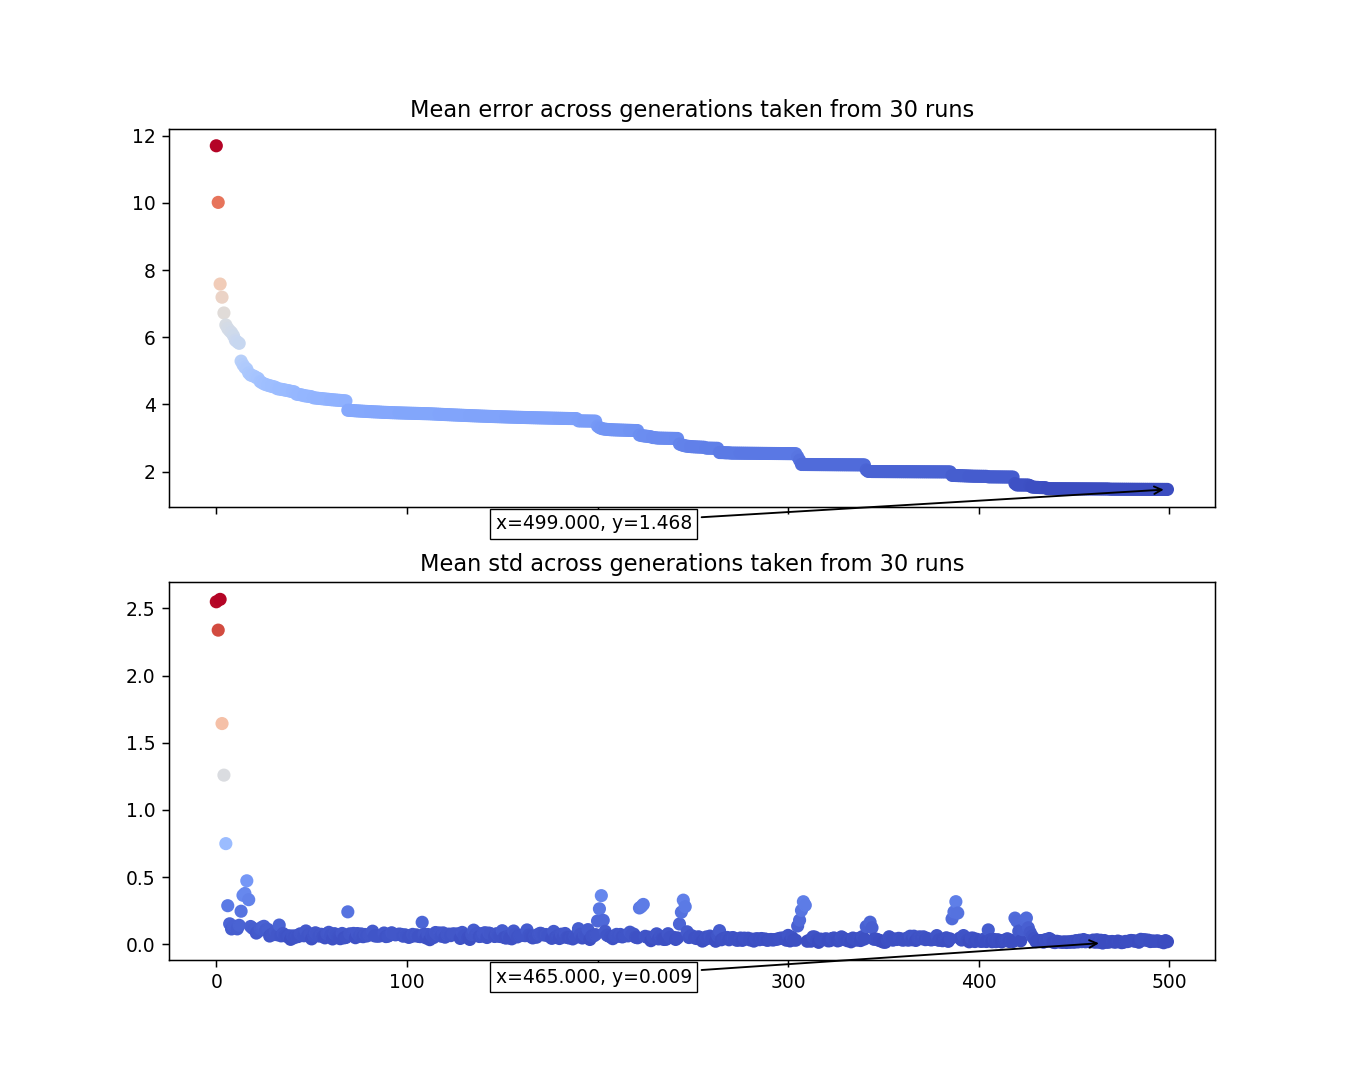

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,3,30,1,0.5,0.01,3.20547


--- Mean computation time 0.5752 seconds ---
--- Mean solution 9.4255 ---
--- Mean std 0.1538 ---


<IPython.core.display.Javascript object>


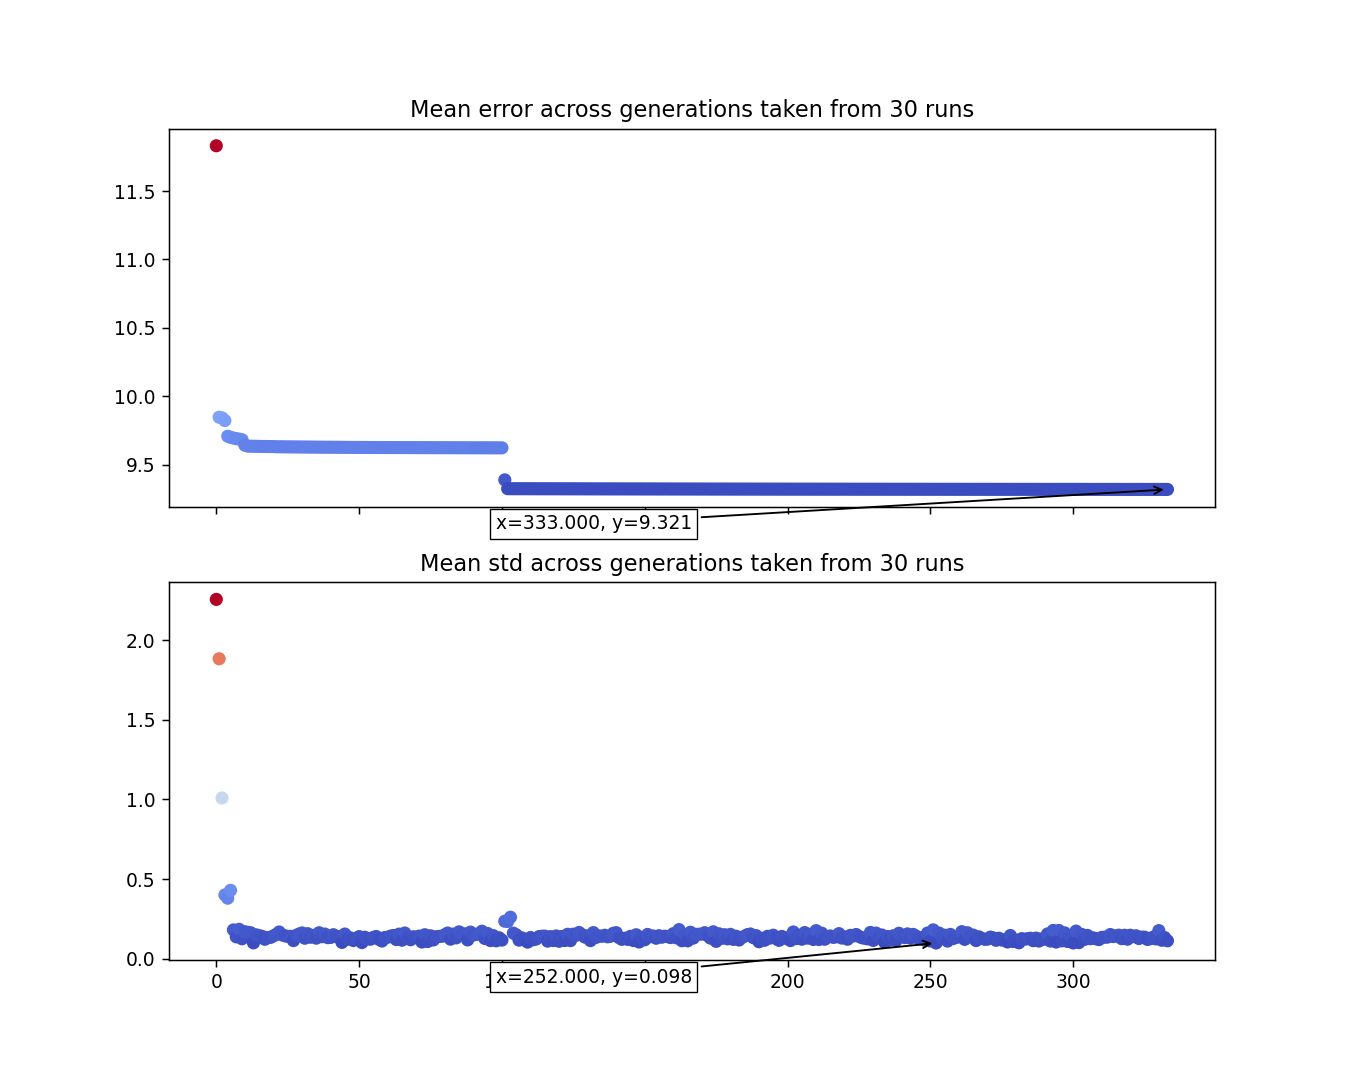

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,3,50,1,0.5,0.01,4.45668


--- Mean computation time 0.6209 seconds ---
--- Mean solution 7.4858 ---
--- Mean std 0.1669 ---


<IPython.core.display.Javascript object>


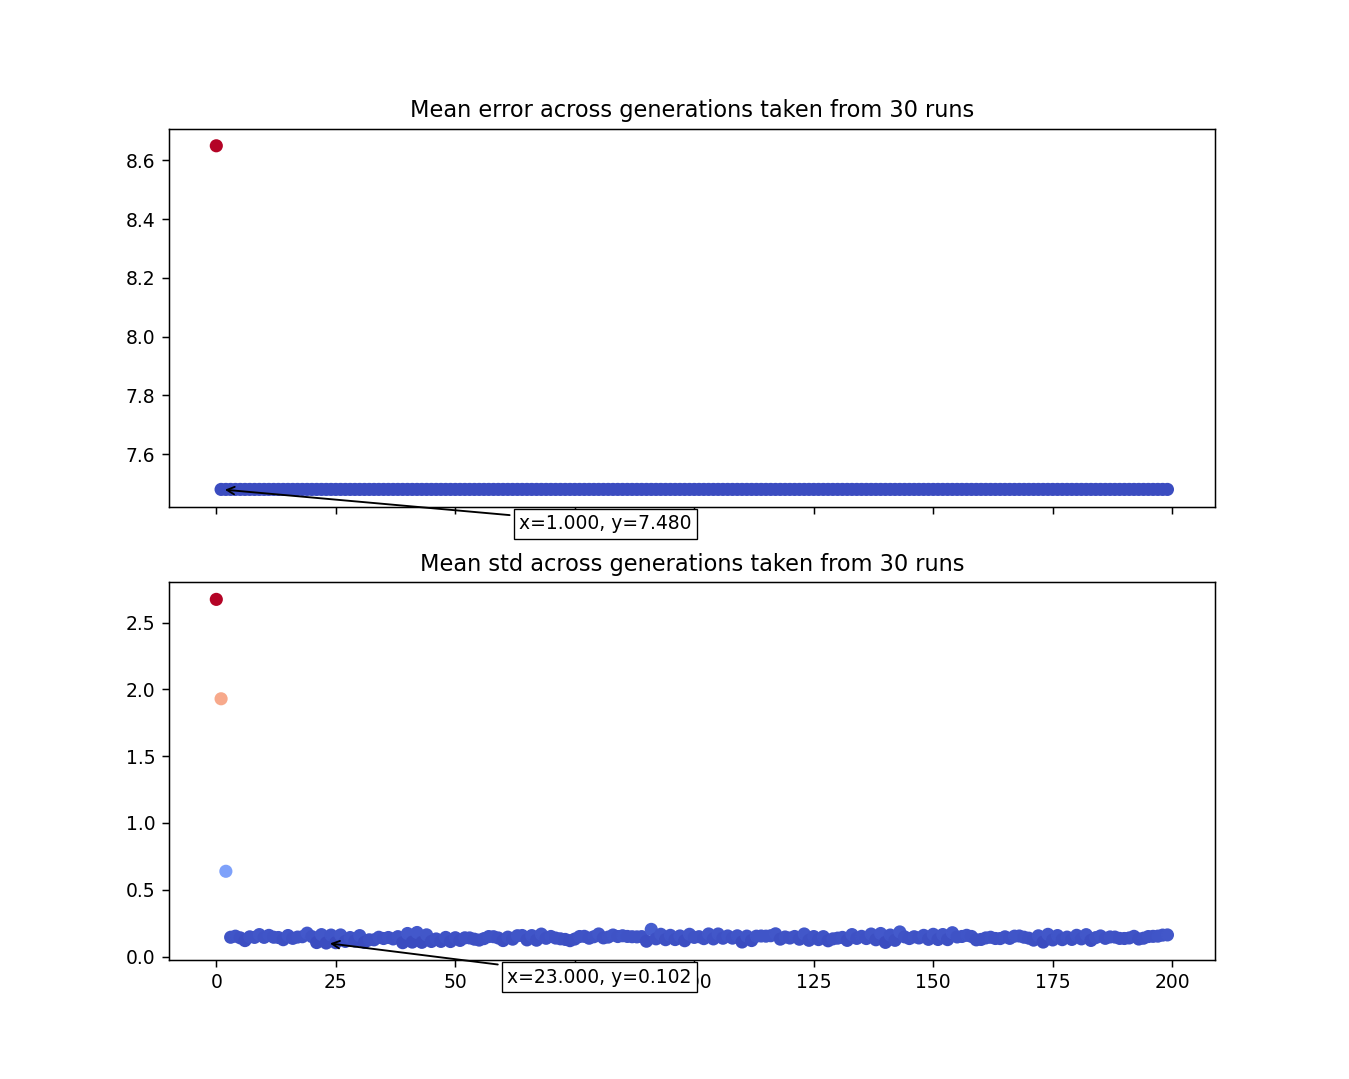

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,ackley,0.729844,MPSO,2.05,0.8,3,20,1,0.5,0.01,0.1


--- Mean computation time 0.6488 seconds ---
--- Mean solution 1.5404 ---
--- Mean std 0.2716 ---


<IPython.core.display.Javascript object>


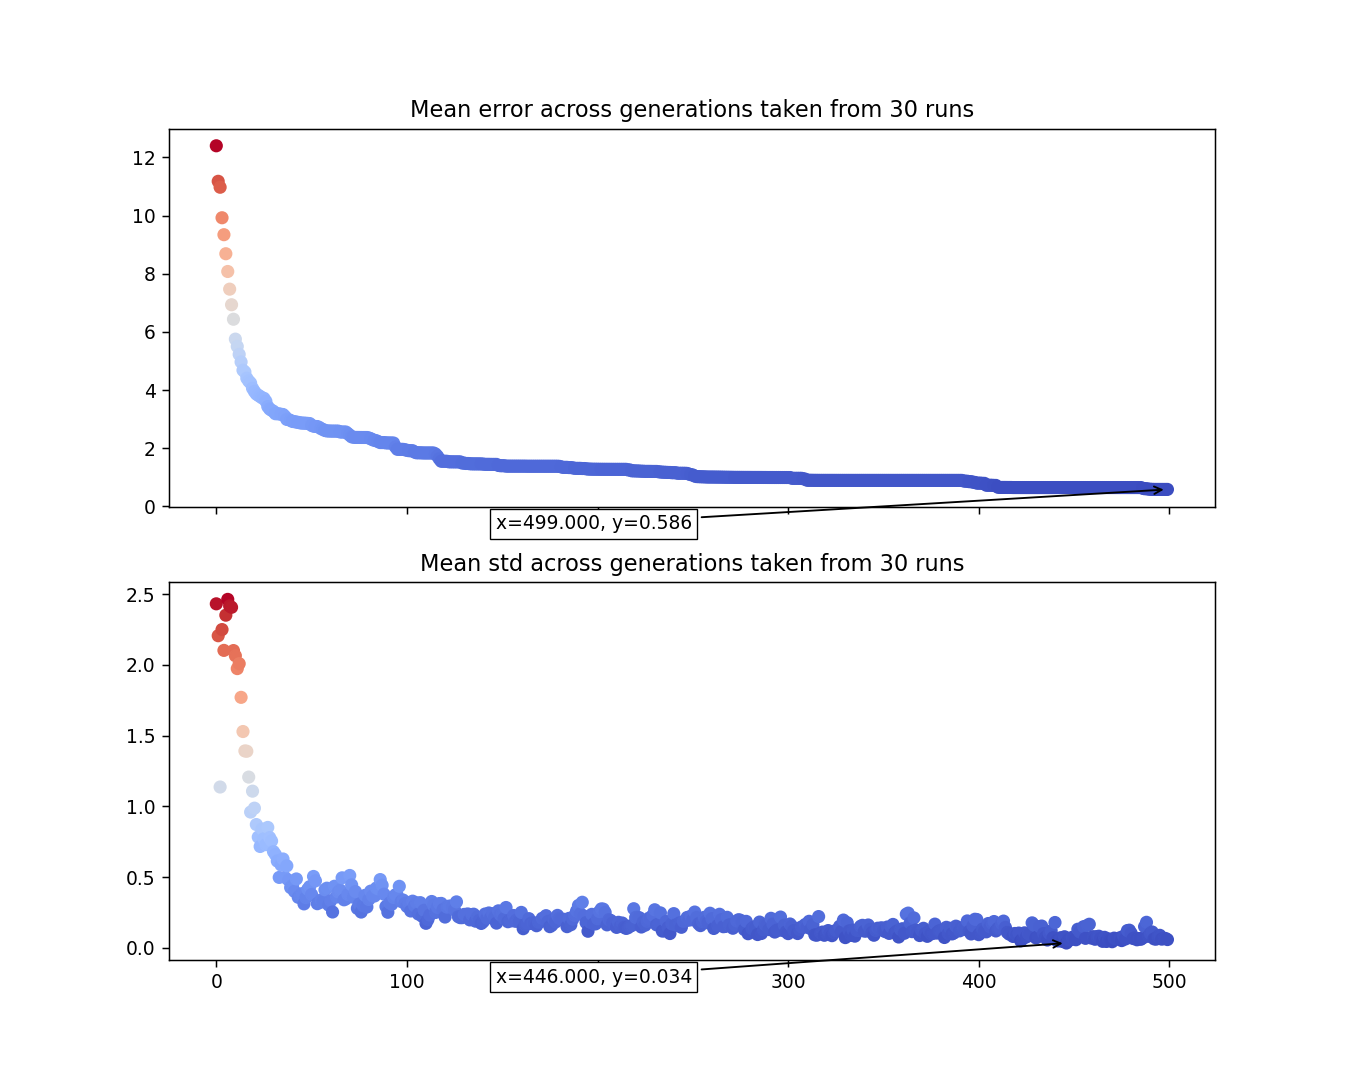

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,ackley,0.729844,MPSO,2.05,0.8,3,30,1,0.5,0.01,0.1


--- Mean computation time 0.6280 seconds ---
--- Mean solution 1.3920 ---
--- Mean std 0.2774 ---


<IPython.core.display.Javascript object>


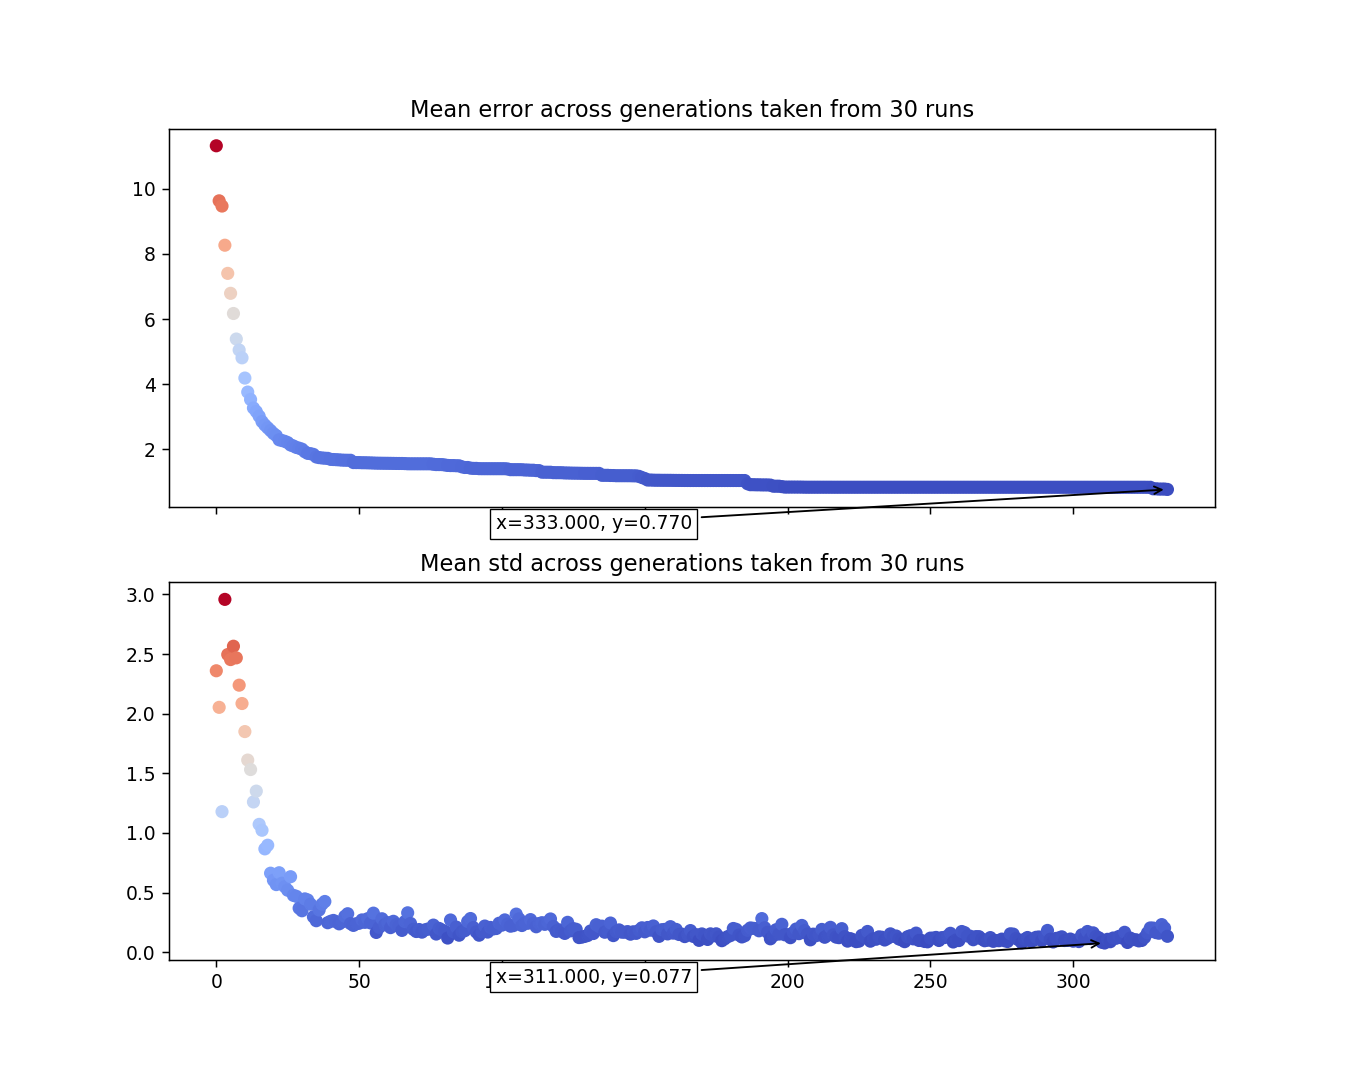

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,ackley,0.729844,MPSO,2.05,0.8,3,50,1,0.5,0.01,0.1


--- Mean computation time 0.6281 seconds ---
--- Mean solution 1.0548 ---
--- Mean std 0.5004 ---


<IPython.core.display.Javascript object>


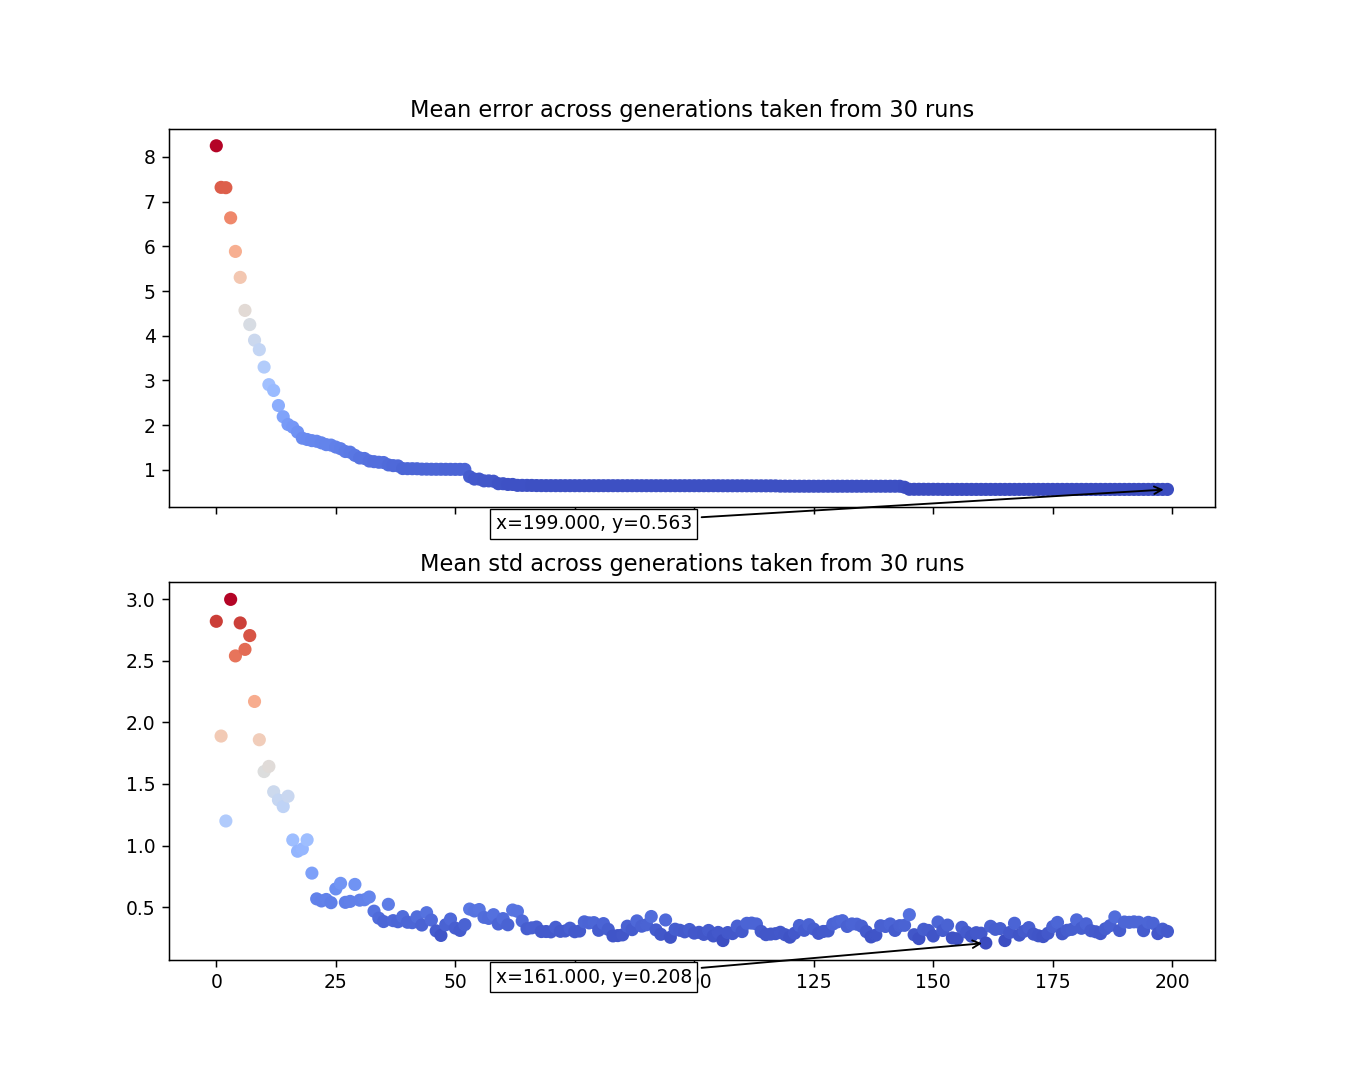

In [13]:
cfg = load_config()
cfg.TYPE = "BOA"
cfg.NPARTICLES = 20
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 30
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 50
run_n_times(n_runs, "NPARTICLES")

cfg = load_config()
cfg.TYPE = "MPSO"
cfg.NPARTICLES = 20
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 30
run_n_times(n_runs, "NPARTICLES")
cfg.NPARTICLES = 50
run_n_times(n_runs, "NPARTICLES")

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,20,30,1,0.5,0.01,0.1


--- Mean computation time 1.1337 seconds ---
--- Mean solution 9.3773 ---
--- Mean std 0.0692 ---


<IPython.core.display.Javascript object>


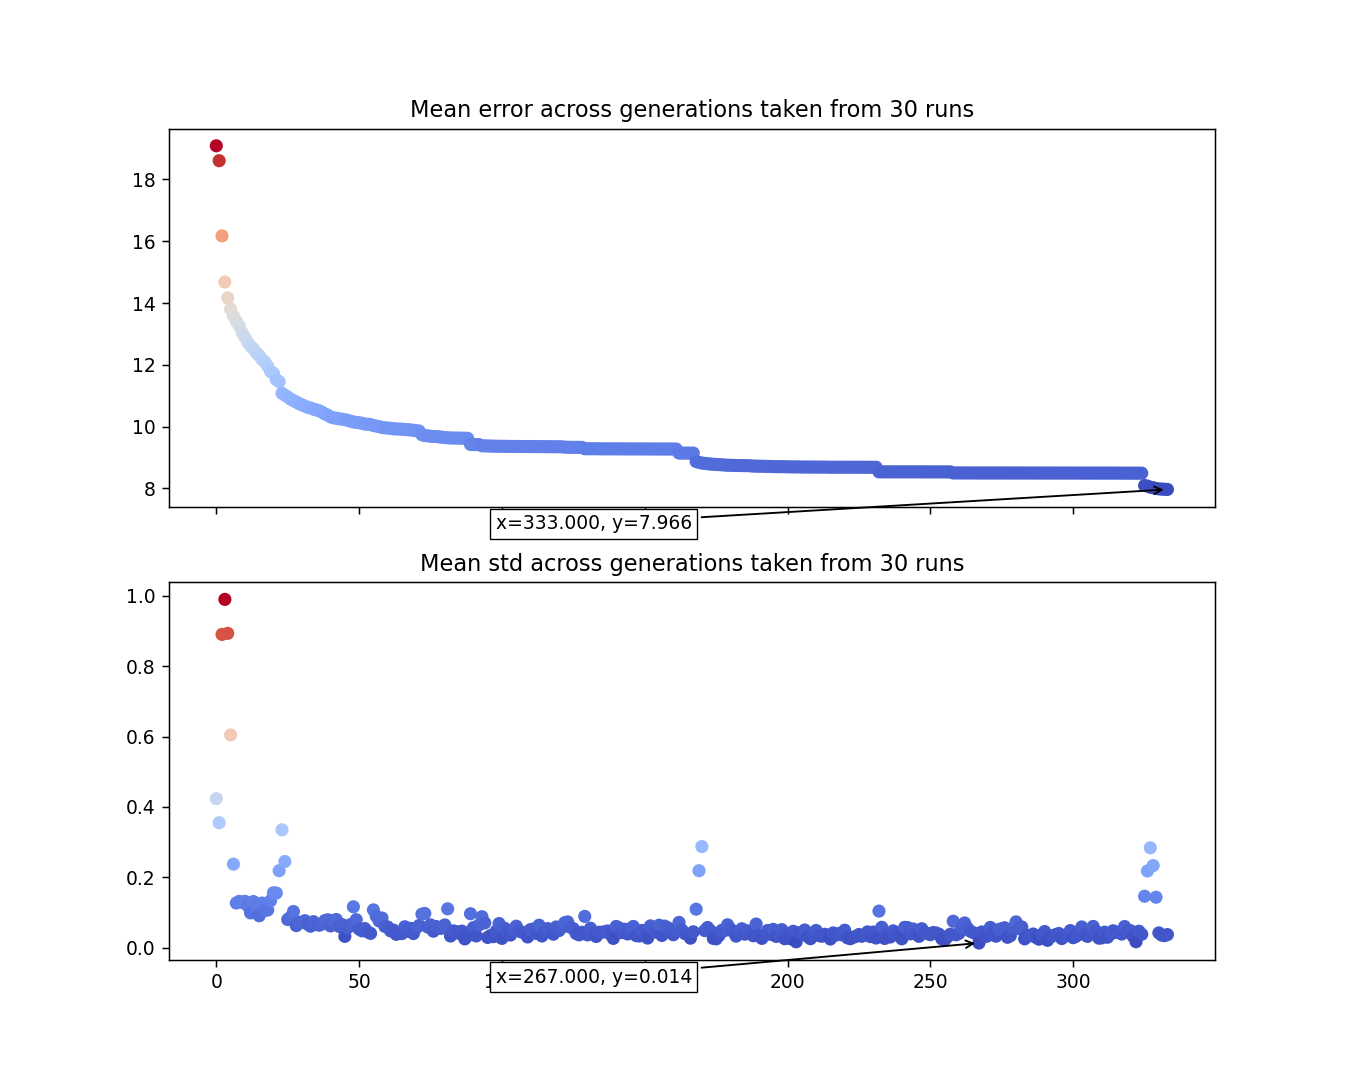

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,30,30,1,0.5,0.01,3.10985


--- Mean computation time 1.4239 seconds ---
--- Mean solution 19.0660 ---
--- Mean std 0.0292 ---


<IPython.core.display.Javascript object>


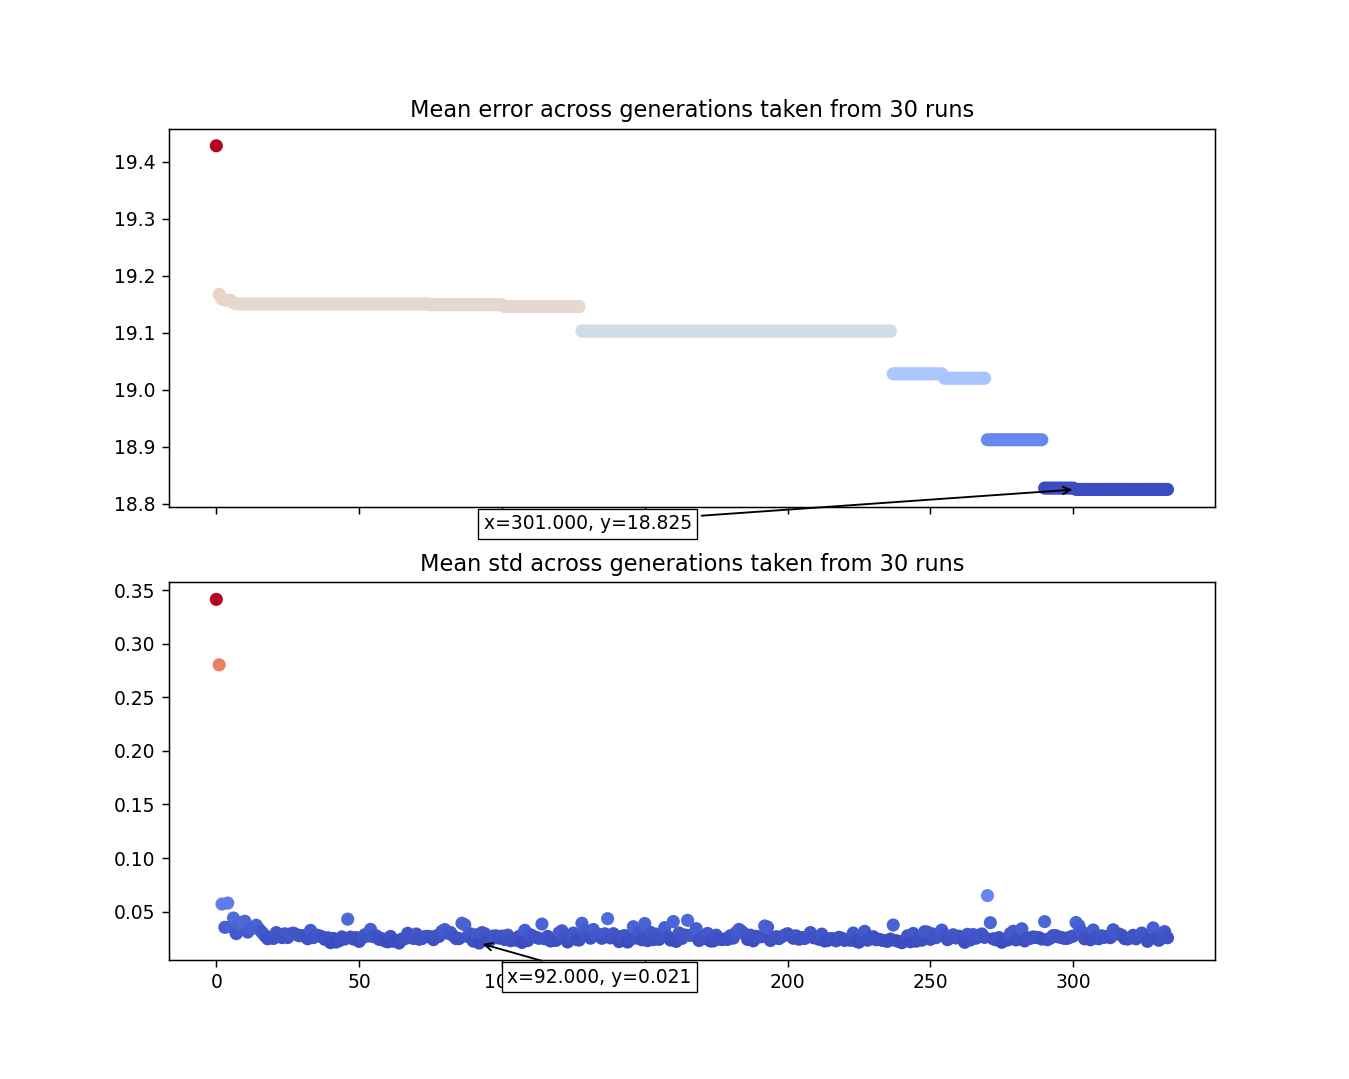

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,ackley,0.729844,MPSO,2.05,0.8,20,30,1,0.5,0.01,0.1


--- Mean computation time 1.3377 seconds ---
--- Mean solution 11.1837 ---
--- Mean std 0.3994 ---


<IPython.core.display.Javascript object>


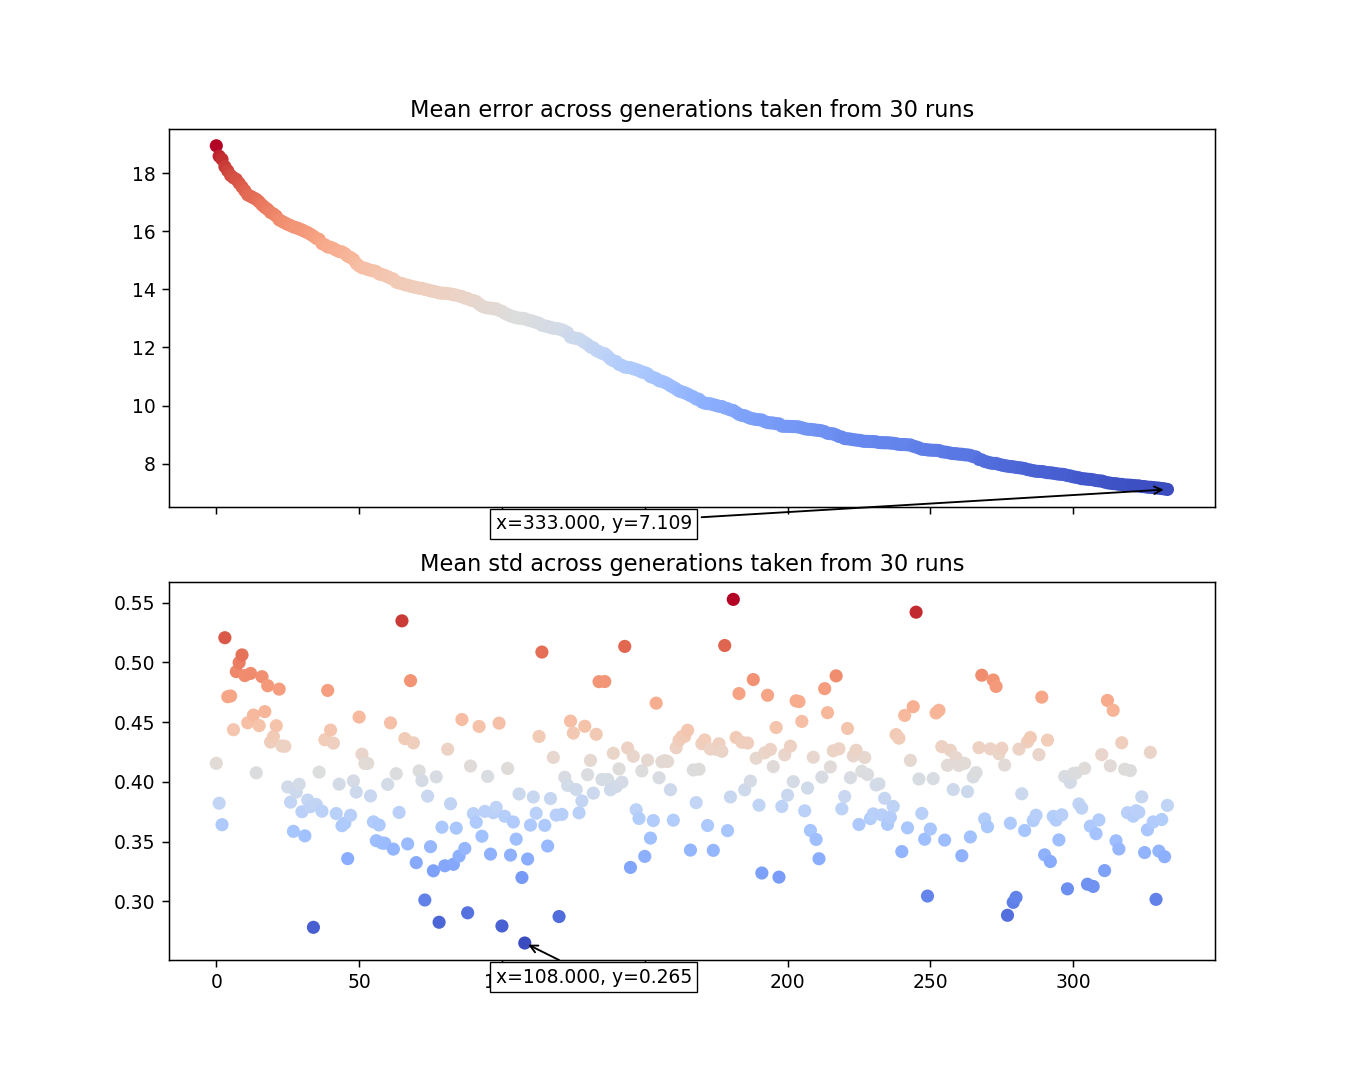

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,ackley,0.729844,MPSO,2.05,0.8,30,30,1,0.5,0.01,0.1


--- Mean computation time 1.6207 seconds ---
--- Mean solution 14.4387 ---
--- Mean std 0.3504 ---


<IPython.core.display.Javascript object>


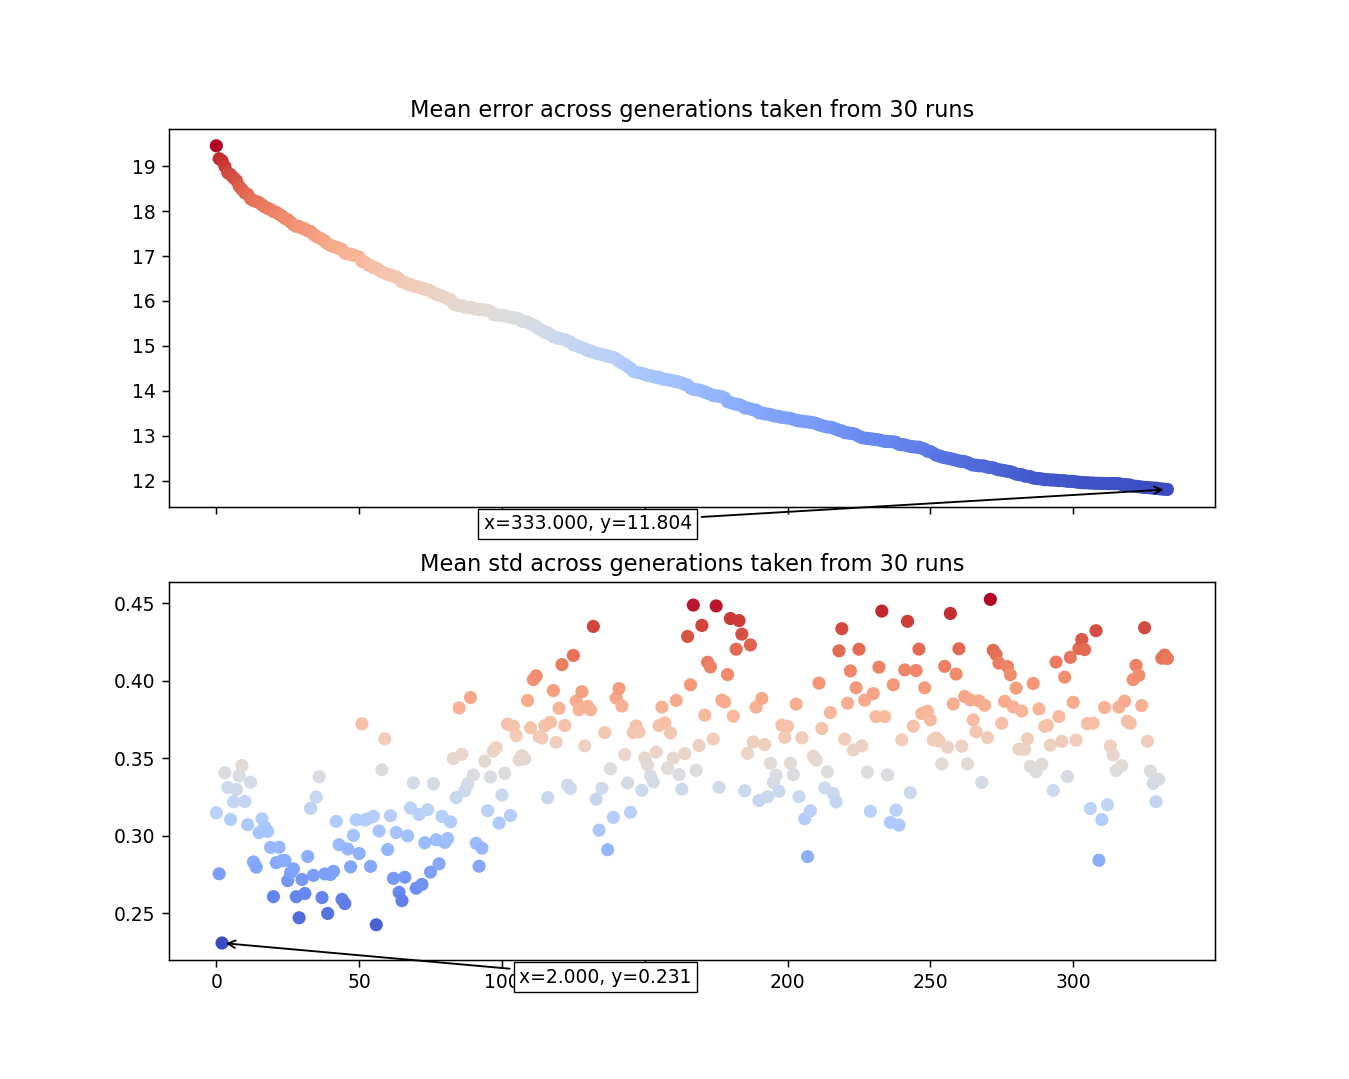

In [14]:
cfg = load_config()
cfg.TYPE = "BOA"
cfg.NPARTICLES = 30
cfg.DIMS = 20
run_n_times(n_runs, "DIMS")
cfg.DIMS = 30
run_n_times(n_runs, "DIMS")

cfg = load_config()
cfg.TYPE = "MPSO"
cfg.NPARTICLES = 30
cfg.DIMS = 20
run_n_times(n_runs, "DIMS")
cfg.DIMS = 30
run_n_times(n_runs, "DIMS")

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,griewank,0.729844,BOA,2.05,0.8,3,20,1,0.5,0.01,0.1


--- Mean computation time 0.6346 seconds ---
--- Mean solution 0.2185 ---
--- Mean std 0.0770 ---


<IPython.core.display.Javascript object>


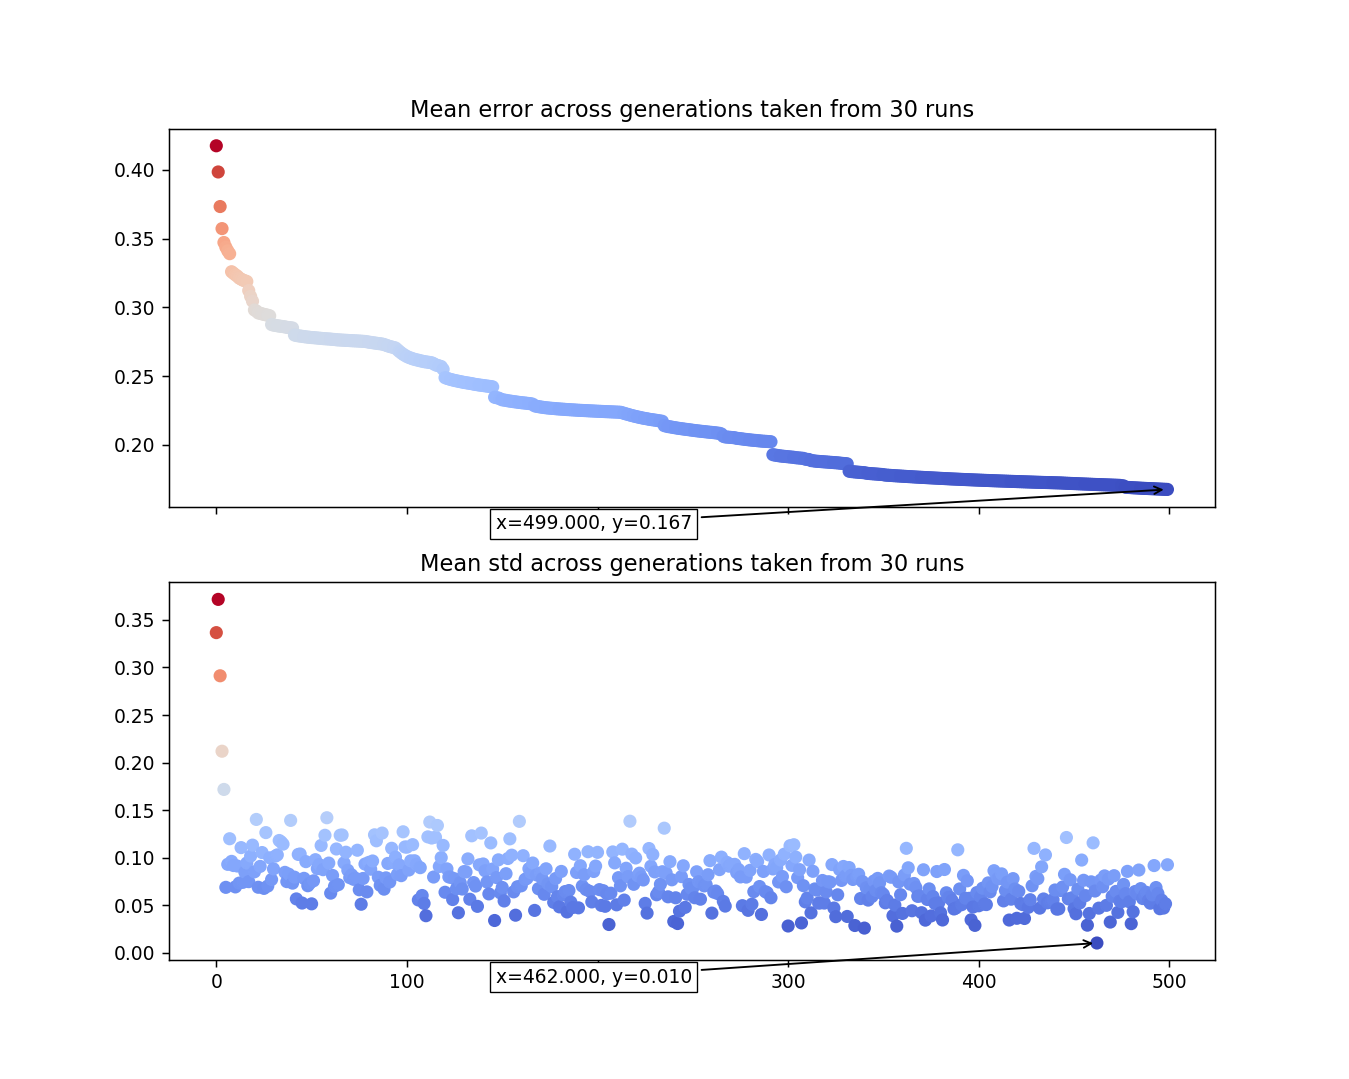

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
BOA,-15,30,ackley,0.729844,BOA,2.05,0.8,3,20,1,0.5,0.01,3.20547


--- Mean computation time 0.5880 seconds ---
--- Mean solution 11.2377 ---
--- Mean std 0.1524 ---


<IPython.core.display.Javascript object>


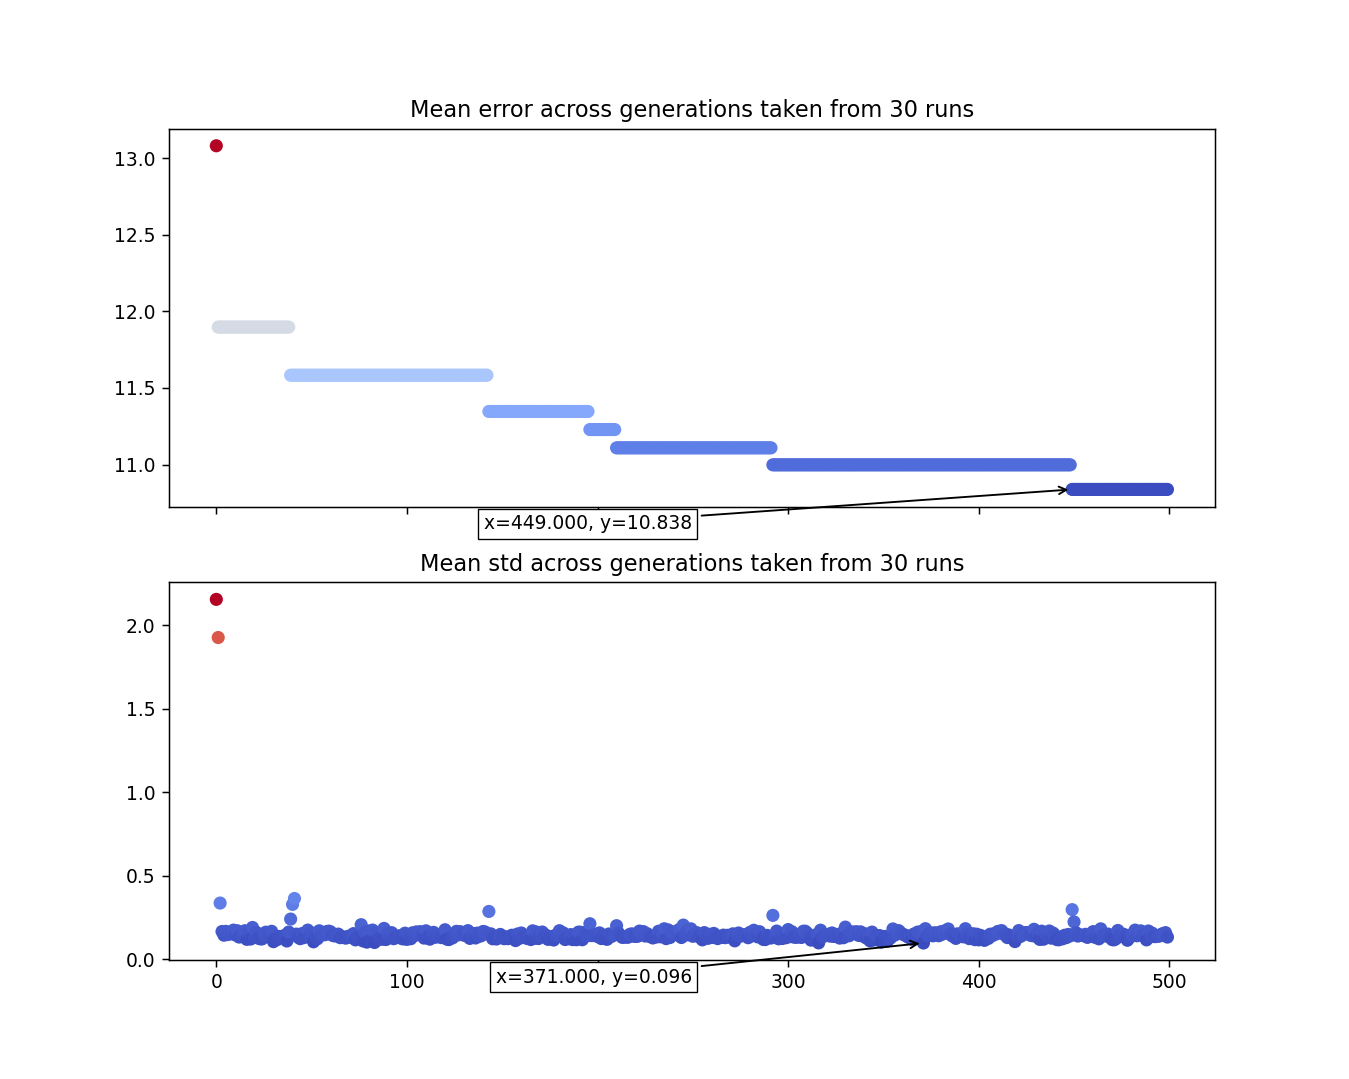

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,griewank,0.729844,MPSO,2.05,0.8,3,20,1,0.5,0.01,0.1


--- Mean computation time 0.6032 seconds ---
--- Mean solution 0.0985 ---
--- Mean std 0.2285 ---


<IPython.core.display.Javascript object>


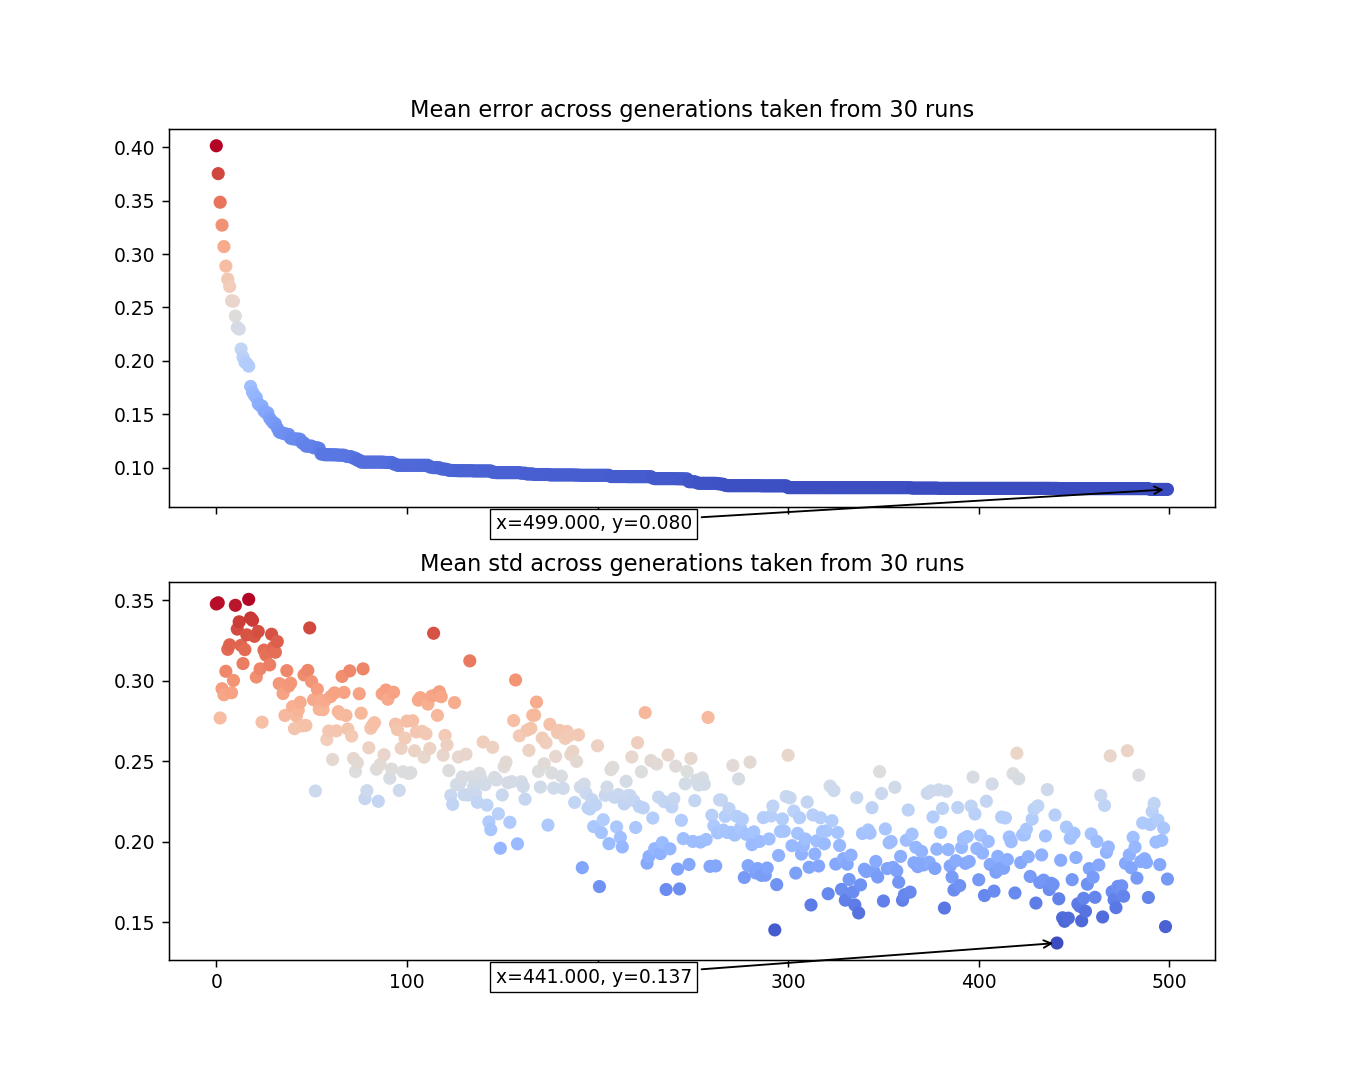

TYPE,MIN_COORD,MAX_COORD,FUNCTION,CHI,TYPE,C,P,DIMS,NPARTICLES,NEXCESS,RCLOUD,BOA_C,BOA_A
MPSO,-15,30,ackley,0.729844,MPSO,2.05,0.8,3,20,1,0.5,0.01,0.1


--- Mean computation time 0.6086 seconds ---
--- Mean solution 0.7133 ---
--- Mean std 0.2862 ---


<IPython.core.display.Javascript object>


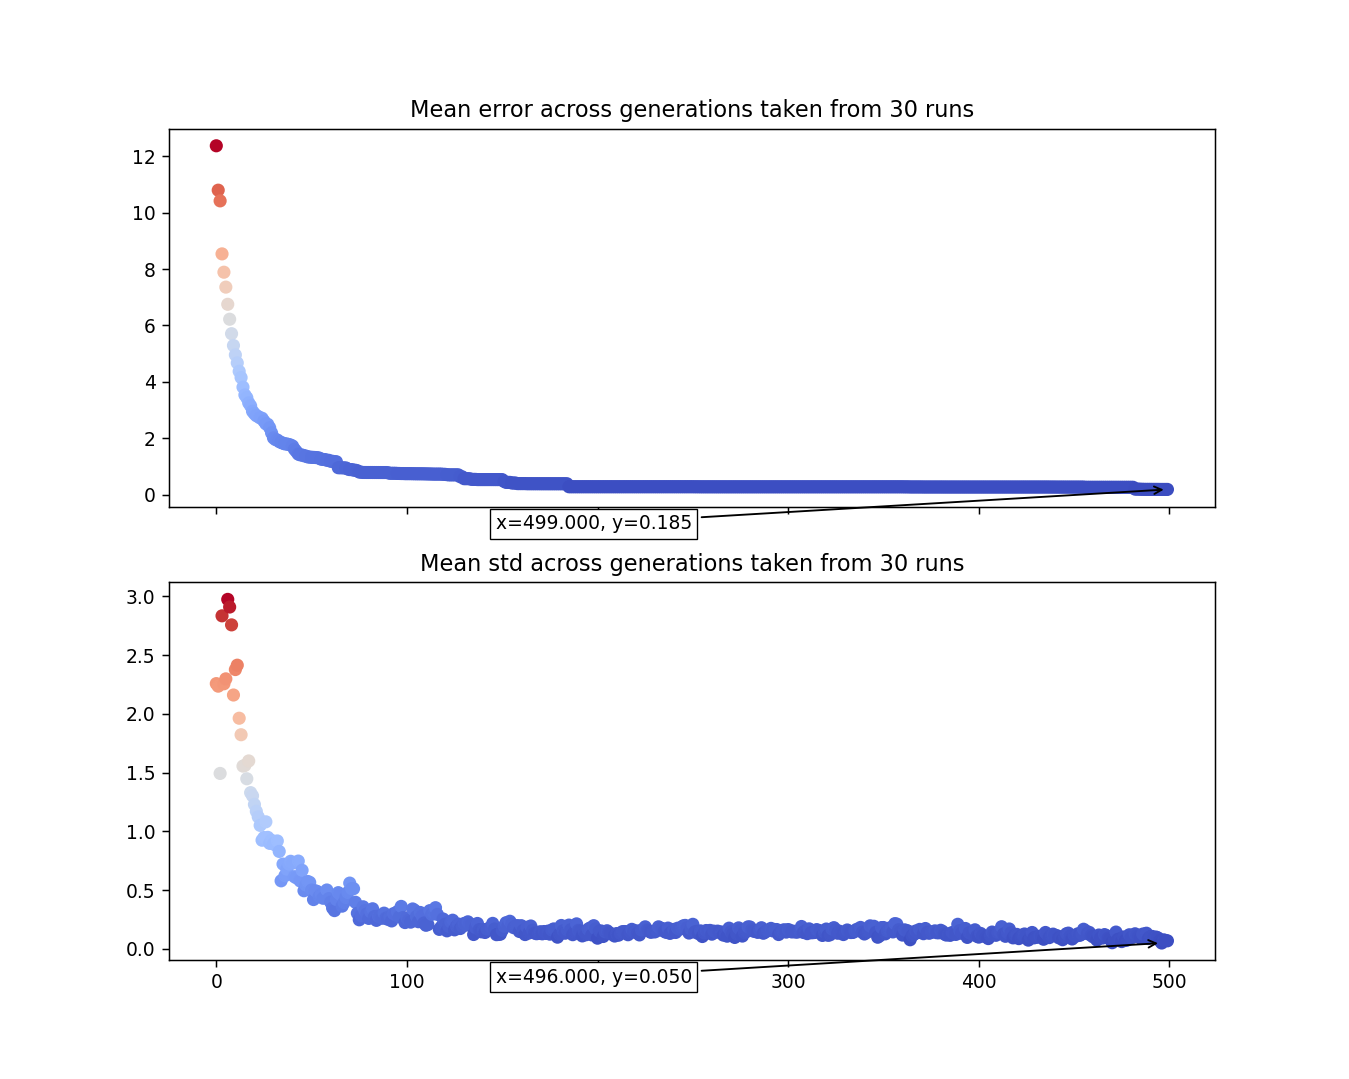

In [15]:
cfg = load_config()
cfg.TYPE = "BOA"
cfg.FUNCTION = "griewank"
run_n_times(n_runs, "griewank")
cfg.FUNCTION = "ackley"
run_n_times(n_runs, "ackley")

cfg = load_config()
cfg.TYPE = "MPSO"
cfg.FUNCTION = "griewank"
run_n_times(n_runs, "griewank")
cfg.FUNCTION = "ackley"
run_n_times(n_runs, "ackley")

## Wnioski i obserwacje końcowe
<div style="text-align: justify">
    <ul>
        <li>Połączenie algorytmów optymalizacji rojem cząstek oraz genetycznego pozwala osiągnąć bardzo dobre rezultaty i szybką zbieżność do rozwiązania.</li>
        <li>W przypadku funkcji Griewanka odchylenie standardowe błędu nie ustabilizowało się w takim stopniu jak w przypadku funkcji Ackleya.</li>
        <li>W niektórych konfiguracjach parametrów dla algorytmu BOA, rój pozostawał w obszarach lokalnego minimum. W przypadku algorytmu PSO spadek błędu był stabilny, a dla mniejszej ilości wymiarów udawało się znaleźć rozwiązanie z dużą dokładnością. </li>
    </ul>
</div>